In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

import torchvision
import torchvision.transforms as tr
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from tqdm import tqdm

import imageio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import copy
import urllib.request

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/models/torch_basic_study"

# Visualization

## Explainable AI, XAI

Class Activation Map

In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/models/torch_basic_study"

In [ ]:
transform = transforms.Compose([transforms.Resize(128), transforms.ToTensor()])
trainset = torchvision.datasets.STL10(root="./data", split="train", download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=40, shuffle=True)
testset = torchvision.datasets.STL10(root="./data", split="test", download=True, transform=transform)
testloader = DataLoader(testset, batch_size=40, shuffle=True)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)
model.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/stl10_resnet18.pt"))

<All keys matched successfully>

In [ ]:
def acc(dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
    model.eval()
    for data in dataloader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print("Accuracy: %d %%" % (100 * correct / total))
acc(trainloader)
acc(testloader)

Accuracy: 99 %
Accuracy: 82 %


In [ ]:
activation = {}
def get_activation(name):
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

In [ ]:
def cam(dataset, img_sample, img_size):
  model.eval()
  with torch.no_grad():
    model.layer4[1].bn2.register_forward_hook(get_activation("final"))
    data, label = dataset[img_sample]
    data.unsqueeze_(0)
    output = model(data.to(device))
    _, prediction =torch.max(output, 1)
    act = activation["final"].squeeze()
    w = model.fc.weight
    for idx in range(act.size(0)):
      if idx == 0:
        tmp = act[idx] * w[prediction.item()][idx]
      else:
        tmp += act[idx] * w[prediction.item()][idx]
    normalized_cam = tmp.cpu().numpy()
    normalized_cam = (normalized_cam - np.min(normalized_cam)) / (np.max(normalized_cam) - np.min(normalized_cam))
    original_img = np.uint8((data[0][0] / 2 + 0.5) * 255)
    cam_img = cv2.resize(np.uint8(normalized_cam * 255), dsize=(img_size, img_size))
  return cam_img, original_img, prediction, label

In [ ]:
def plot_cam(dataset, img_size, start):
  end = start + 20
  fig, axs = plt.subplots(2, (end - start + 1) // 2, figsize = (20, 4))
  fig.subplots_adjust(hspace=.01, wspace=.01)
  axs = axs.ravel()
  cls = ["airplabe", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]
  for i in range(start, end):
    cam_img, original_img, prediction, label = cam(dataset, i, img_size)
    if prediction == label:
      color = "white"
    else:
      color = "red"
    axs[i - start].imshow(original_img, cmap="gray")
    axs[i - start].imshow(cam_img, cmap="jet", alpha=.4)
    axs[i - start].text(5, 5, cls[prediction], bbox={"facecolor":color, "pad":5})
    axs[i - start].axis("off")
  plt.show()

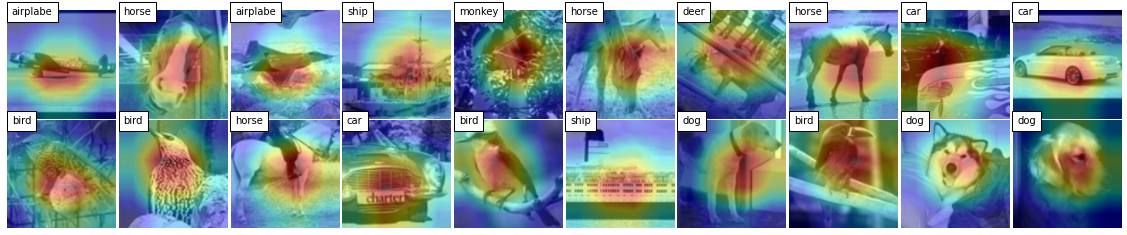

In [ ]:
plot_cam(trainset, 128, 10)

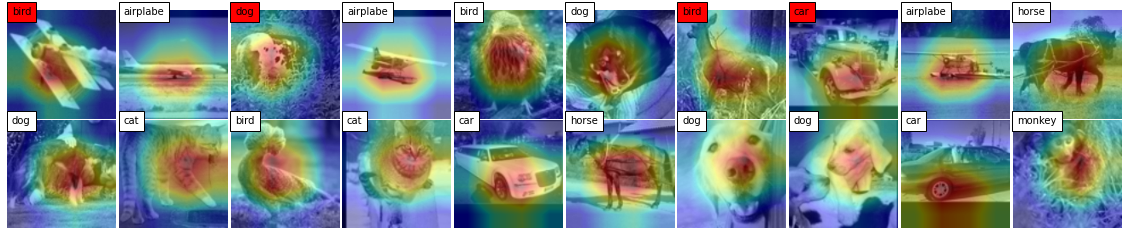

In [ ]:
plot_cam(testset, 128, 10)

## Dimension Reduction Techniques

t-SNE : t-distributed Stochastic Neighbor Embedding

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/models/torch_basic_study"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5, .5, .5), (.5, .5, .5))])
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=6)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
class Identity(nn.Module):
  def __init__(self):
    super(Identity, self).__init__()
  def forward(self, x):
    return x
model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)
model.load_state_dict(torch.load(f"{MODEL_SAVE_PATH}/cifar10_resnet18.pt"))
model.fc = Identity()

In [ ]:
actual = []
deep_features = []
model.eval()
with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    features = model(images)
    deep_features += features.cpu().tolist()
    actual += labels.cpu().tolist()

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)
print(cluster.shape)
print(actual.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


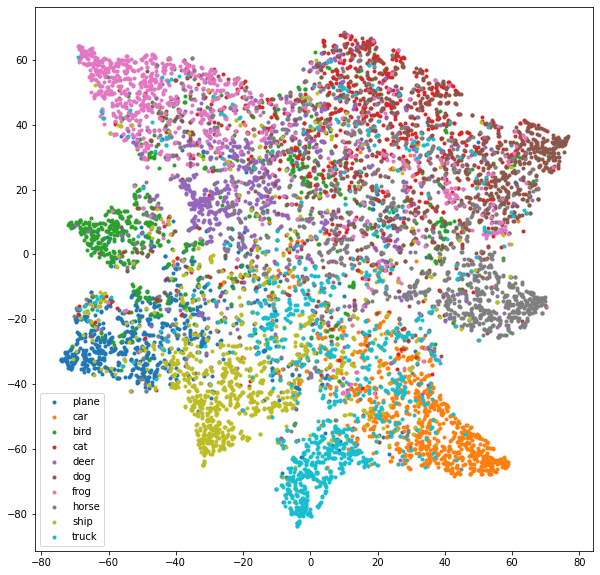

In [ ]:
plt.figure(figsize=(10, 10))
cifar = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
for i, label in zip(range(10), cifar):
  idx = np.where(actual == i)
  plt.scatter(cluster[idx, 0], cluster[idx, 1], marker=".", label=label)
plt.legend()
plt.show()

PCA : Principal Component Analysis

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
cluster = np.array(pca.fit_transform(np.array(deep_features)))
print(pca.explained_variance_ratio_)
print(cluster.shape)

[0.21694763 0.17314635]


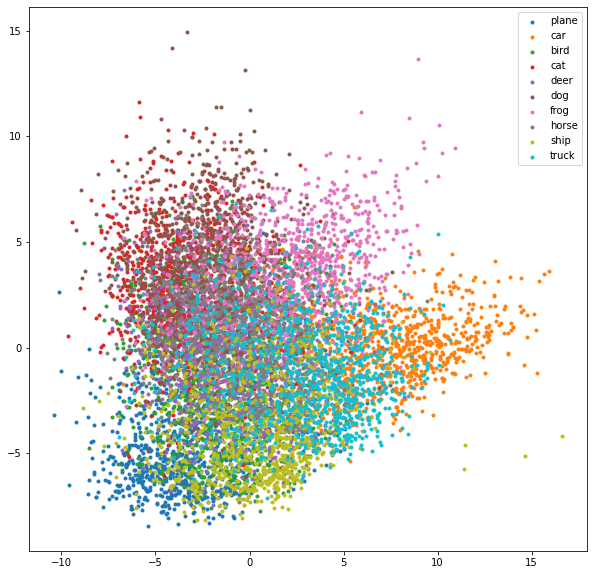

In [ ]:
plt.figure(figsize=(10, 10))
cifar = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
for i, label in zip(range(10), cifar):
  idx = np.where(actual == i)
  plt.scatter(cluster[idx, 0], cluster[idx, 1], marker=".", label=label)
plt.legend()
plt.show()